In [12]:
import hydra
from omegaconf import OmegaConf
import pyrootutils

root = pyrootutils.setup_root(".", pythonpath=True)
model_cfg = OmegaConf.load(root / "configs" / "model" / "ddpm_mnist.yaml")
model_cfg.ckpt_path = "../checkpoints/last.ckpt"
model = hydra.utils.instantiate(model_cfg)

DDPM: Running in eps-prediction mode
Keeping EMAs of 186.
Restored from ../checkpoints/last.ckpt with 0 missing and 12 unexpected keys
Unexpected Keys: ['betas', 'alphas_cumprod', 'alphas_cumprod_prev', 'sqrt_alphas_cumprod', 'sqrt_one_minus_alphas_cumprod', 'log_one_minus_alphas_cumprod', 'sqrt_recip_alphas_cumprod', 'sqrt_recipm1_alphas_cumprod', 'posterior_variance', 'posterior_log_variance_clipped', 'posterior_mean_coef1', 'posterior_mean_coef2']


In [16]:
import torch
ckpt = torch.load("../checkpoints/last.ckpt")
ckpt.keys()

dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'loops', 'callbacks', 'optimizer_states', 'lr_schedulers', 'datamodule_hparams_name', 'datamodule_hyper_parameters'])

In [13]:
import torch
torch.cuda.empty_cache()
model = model.cuda()
samples = model.sample(batch_size=4)

Sampling t: 100%|██████████| 1000/1000 [00:30<00:00, 32.82it/s]


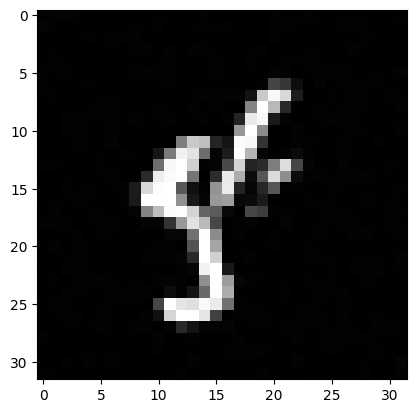

In [15]:
import matplotlib.pyplot as plt

plt.imshow(samples[2, 0].cpu().numpy(), cmap="gray")